Starting...
------------------------------
Runner Profile: Speed=25, Ammo=1
Survival Probability: 0.9979
Prediction: SURVIVOR
------------------------------


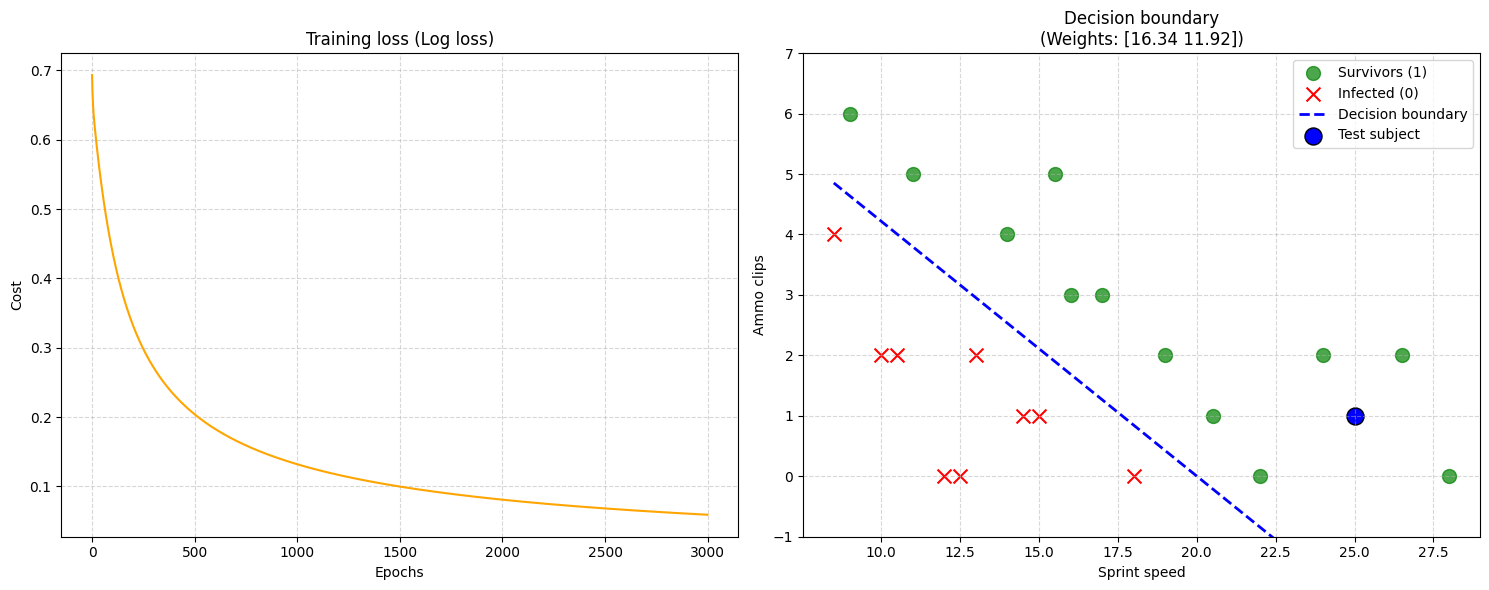

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# Logic: High speed (>18) OR high ammo (>4) increases survival chance.

raw_x = [] # [speed, ammo]
raw_y = [] # 0 or 1

with open('zombies_data.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        if row:
            # [speed,ammo]
            raw_x.append([float(row[0]), float(row[1])])
            raw_y.append(float(row[2]))

X = np.array(raw_x)
Y = np.array(raw_y)

X_min = np.min(X, axis=0)
X_max = np.max(X, axis=0)
X_scaled = (X-X_min)/(X_max-X_min)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def compute_cost(h, y): # Log Loss
    return (-y*np.log(h+1e-15)-(1-y)*np.log(1-h+1e-15)).mean()

learning_rate = 0.5
epochs = 3000

# (w1, w2) and (b)
weights = np.zeros(X.shape[1])
bias = 0
n_samples = len(X)

cost_history = []

print("Starting...")

for i in range(epochs):
    # linear model: z = w1*x1+w2*x2+b
    z = np.dot(X_scaled, weights)+bias

    # activation
    h = sigmoid(z)

    error = h-Y
    dw = (1/n_samples)*np.dot(X_scaled.T, error)
    db = (1/n_samples)*np.sum(error)

    weights -= learning_rate*dw
    bias -= learning_rate*db

    cost = compute_cost(h, Y)
    cost_history.append(cost)

runner_profile = np.array([25, 1])
runner_scaled = (runner_profile-X_min)/(X_max-X_min)

# probability
z_pred = np.dot(runner_scaled, weights)+bias
prob = sigmoid(z_pred)
prediction = 1 if prob >= 0.5 else 0

result_text = "SURVIVOR" if prediction == 1 else "INFECTED"

print("-"*30)
print(f"Runner Profile: Speed={runner_profile[0]}, Ammo={runner_profile[1]}")
print(f"Survival Probability: {prob:.4f}")
print(f"Prediction: {result_text}")
print("-"*30)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(range(epochs), cost_history, color='orange')
ax1.set_title('Training loss (Log loss)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cost')
ax1.grid(True, linestyle='--', alpha=0.5)

survivors = X[Y == 1]
infected = X[Y == 0]

ax2.scatter(survivors[:, 0], survivors[:, 1], color='green', label='Survivors (1)', s=100, alpha=0.7)
ax2.scatter(infected[:, 0], infected[:, 1], color='red', label='Infected (0)', marker='x', s=100)

# The boundary is where sigmoid(z) = 0.5, which means z = 0
# z = w1*x1+w2*x2+b = 0
# want to solve for x2 (ammo) in terms of x1 (speed) to plot the line y=mx+c
# w1*x1+w2*x2+b = 0  =>  x2 = -(w1*x1+b)/w2
x_values_scaled = np.linspace(0, 1, 100)
y_values_scaled = -(weights[0]*x_values_scaled+bias)/weights[1]

# denormalize
x_values_original = x_values_scaled*(X_max[0]-X_min[0])+X_min[0]
y_values_original = y_values_scaled*(X_max[1]-X_min[1])+X_min[1]

ax2.plot(x_values_original, y_values_original, color='blue', linestyle='--', linewidth=2, label='Decision boundary')
ax2.scatter(runner_profile[0], runner_profile[1], color='blue', s=150, edgecolors='black', label='Test subject')
ax2.set_title(f'Decision boundary\n(Weights: {weights.round(2)})')
ax2.set_xlabel('Sprint speed')
ax2.set_ylabel('Ammo clips')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_ylim(min(X[:,1])-1, max(X[:,1])+1)

plt.tight_layout()
plt.show()